## **1. Data Preparation**

1-1. 평가용 data 파일 및 google drive 수동 upload 필요함

In [2]:
%cd /content/drive/MyDrive/Colab\ Notebooks/mixing_chart/

/content/drive/MyDrive/Colab Notebooks/mixing_chart


In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [200]:
df = pd.read_csv("modified_chart.csv")

In [201]:
df.head()

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23,s24,s25,s26,s27,s28,s29,s30,s31,s32,s33,s34,s35,s36,s37,s38,s39,s40,s41,s42,s43,s44,s45,s46,s47,s48,s49,s50,s51,s52,s53,s54,s55,s56,s57,s58,s59,s60,s61,s62,s63,s64,s65,s66,s67,s68,s69,s70,s71,s72,s73,ml,tmin,tmax,t90,M300
0,16,16,16,16,16,37,106,215,232,255,387,387,404,404,381,386,370,331,331,340,370,418,394,408,406,388,411,398,398,388,401,373,386,332,332,193,182,178,194,238,259,294,332,345,387,391,417,408,412,423,406,423,411,429,423,420,434,417,417,417,345,185,185,159,191,231,264,281,314,347,363,357,363,54.9,3.12,23.93,8.10,106.0
1,27,263,263,419,498,498,498,510,464,410,421,403,403,394,446,462,505,505,465,465,476,444,444,440,446,428,414,414,414,373,283,237,148,170,207,243,294,294,353,389,384,412,418,428,414,416,414,414,430,426,412,416,416,420,330,330,208,208,208,237,237,274,302,317,347,347,350,336,359,339,339,341,323,56.0,3.15,23.89,7.95,103.0
2,16,18,83,275,406,467,558,565,584,584,515,453,451,429,429,440,488,474,522,490,484,501,462,455,455,449,436,438,428,428,428,234,257,257,257,270,339,353,383,392,385,403,398,406,406,402,413,396,406,396,385,403,390,402,402,402,230,230,230,201,208,264,284,307,307,329,320,339,339,321,332,318,325,56.9,3.36,22.69,8.20,105.0
3,49,61,76,76,589,589,512,512,488,485,406,400,400,422,418,428,459,481,444,521,492,477,471,472,486,464,459,465,375,261,261,213,213,252,270,317,387,406,389,407,422,402,418,404,401,416,409,409,391,412,405,412,412,399,374,291,245,224,213,204,225,269,299,322,336,329,340,337,333,340,343,337,337,53.9,3.14,23.74,10.35,94.0
4,46,68,86,86,86,68,536,536,581,610,559,494,412,412,406,471,509,527,501,553,515,518,498,498,513,521,514,493,501,470,405,279,245,221,195,232,263,339,339,393,398,412,422,406,427,431,423,425,425,444,431,439,442,442,450,439,375,301,224,224,216,211,237,265,290,315,340,346,356,363,349,354,352,54.4,3.11,24.85,8.17,102.0


1-2. Tmax를 예측하기 위해, Tmin, ml, t90, M300 물성 제외

In [202]:
df2 = df.drop(columns = ["ml", "tmin", "t90", "M300"])

In [203]:
df2.head()

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23,s24,s25,s26,s27,s28,s29,s30,s31,s32,s33,s34,s35,s36,s37,s38,s39,s40,s41,s42,s43,s44,s45,s46,s47,s48,s49,s50,s51,s52,s53,s54,s55,s56,s57,s58,s59,s60,s61,s62,s63,s64,s65,s66,s67,s68,s69,s70,s71,s72,s73,tmax
0,16,16,16,16,16,37,106,215,232,255,387,387,404,404,381,386,370,331,331,340,370,418,394,408,406,388,411,398,398,388,401,373,386,332,332,193,182,178,194,238,259,294,332,345,387,391,417,408,412,423,406,423,411,429,423,420,434,417,417,417,345,185,185,159,191,231,264,281,314,347,363,357,363,23.93
1,27,263,263,419,498,498,498,510,464,410,421,403,403,394,446,462,505,505,465,465,476,444,444,440,446,428,414,414,414,373,283,237,148,170,207,243,294,294,353,389,384,412,418,428,414,416,414,414,430,426,412,416,416,420,330,330,208,208,208,237,237,274,302,317,347,347,350,336,359,339,339,341,323,23.89
2,16,18,83,275,406,467,558,565,584,584,515,453,451,429,429,440,488,474,522,490,484,501,462,455,455,449,436,438,428,428,428,234,257,257,257,270,339,353,383,392,385,403,398,406,406,402,413,396,406,396,385,403,390,402,402,402,230,230,230,201,208,264,284,307,307,329,320,339,339,321,332,318,325,22.69
3,49,61,76,76,589,589,512,512,488,485,406,400,400,422,418,428,459,481,444,521,492,477,471,472,486,464,459,465,375,261,261,213,213,252,270,317,387,406,389,407,422,402,418,404,401,416,409,409,391,412,405,412,412,399,374,291,245,224,213,204,225,269,299,322,336,329,340,337,333,340,343,337,337,23.74
4,46,68,86,86,86,68,536,536,581,610,559,494,412,412,406,471,509,527,501,553,515,518,498,498,513,521,514,493,501,470,405,279,245,221,195,232,263,339,339,393,398,412,422,406,427,431,423,425,425,444,431,439,442,442,450,439,375,301,224,224,216,211,237,265,290,315,340,346,356,363,349,354,352,24.85


1-3. Train, Test Dataset 분리 (80:20)

In [204]:
train_dataset = df2.sample(frac=0.8, random_state=0)
test_dataset = df2.drop(train_dataset.index)

In [205]:
train_labels = train_dataset.pop("tmax")
test_labels = test_dataset.pop("tmax")

1-3. Reshape the input data

In [206]:
train_reshape = train_dataset.values.reshape(40, 73, 1)
label_reshape = train_labels.values.reshape(40, 1, 1)
test_reshape = test_dataset.values.reshape(10, 73, 1)
testlabel_reshape = test_labels.values.reshape(10, 1, 1)

## **2. Convolution Neural Network Analysis**

**2-1. Neural Network Model**

In [81]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [217]:
def build_model():
 model = keras.Sequential([
   layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
   layers.Dense(64, activation='relu'),
   layers.Dense(64, activation='relu'),
   layers.Dense(1)
 ])
 optimizer = tf.keras.optimizers.RMSprop(0.001)
 model.compile(loss='mse',
               optimizer='Adam',
               metrics=['mae', 'mse'])
 return model

In [218]:
model = build_model()

In [220]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 64)                4736      
_________________________________________________________________
dense_57 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_58 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 65        
Total params: 13,121
Trainable params: 13,121
Non-trainable params: 0
_________________________________________________________________


In [238]:
history2 = model.fit(train_dataset, train_labels, epochs=100, validation_split = 0.3, verbose=0, callbacks=[PrintDot()])


....................................................................................................

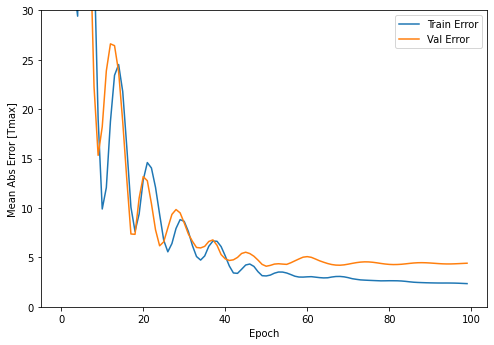

In [239]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure(figsize=(8,12))
  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Tmax]')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
  plt.ylim([0,30])
  plt.legend()

plot_history(history2)

In [255]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)
print("테스트 셋의 평균 오차 : {:5.2f} Tmax".format(mae))

1/1 - 0s - loss: 105.7284 - mae: 5.7479 - mse: 105.7284
테스트 셋의 평균 오차 :  5.75 Tmax


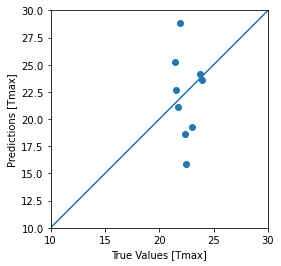

In [259]:
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Tmax]')
plt.ylabel('Predictions [Tmax]')
plt.axis('equal')
plt.axis('square')
plt.xlim(10,30)
plt.ylim(10,30)
_ = plt.plot([-100, 100], [-100, 100])

**2-2. 1D Convolutional Neural Network Model**

In [248]:
def build_cnn_model():
 model = keras.Sequential([
   layers.Conv1D(filters = 64, kernel_size = 10, activation='relu', input_shape=(73, 1)),
   layers.Conv1D(filters = 32, kernel_size = 5, activation='relu'),
   layers.Conv1D(filters = 16, kernel_size = 3, activation='relu'),
   layers.MaxPooling1D(2),
   layers.Flatten(),
   layers.Dense(10, activation='relu'),

   layers.Dense(1)
 ])

 optimizer = tf.keras.optimizers.RMSprop(0.001)
 model.compile(loss='mse',
               optimizer='Adam',
               metrics=['mae', 'mse'])
 return model

In [250]:
cnn_model = build_cnn_model()
cnn_model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 64, 64)            704       
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 60, 32)            10272     
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 58, 16)            1552      
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 29, 16)            0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 464)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 10)                4650      
_________________________________________________________________
dense_69 (Dense)             (None, 1)               

In [251]:
cnn_history = cnn_model.fit(train_reshape, label_reshape, epochs=3000, validation_split = 0.3, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

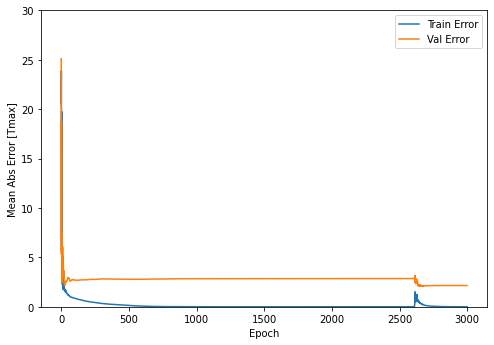

In [252]:
plot_history(cnn_history)

In [254]:
loss, mae, mse = cnn_model.evaluate(test_reshape, testlabel_reshape, verbose=2)
print("테스트 셋의 평균 오차 : {:5.2f} Tmax".format(mae))

1/1 - 0s - loss: 13.6958 - mae: 2.6384 - mse: 13.6958
테스트 셋의 평균 오차 :  2.64 Tmax


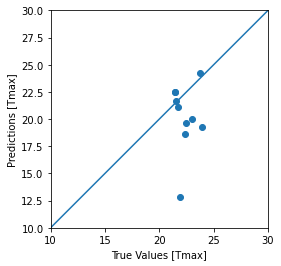

In [260]:
test_cnn_predictions = cnn_model.predict(test_reshape).flatten()

plt.scatter(test_labels, test_cnn_predictions)
plt.xlabel('True Values [Tmax]')
plt.ylabel('Predictions [Tmax]')
plt.axis('equal')
plt.axis('square')
plt.xlim(10,30)
plt.ylim(10,30)
_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
from google.colab import files

model4.save("cnn_model.h5")
files.download('cnn_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>